In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



In [2]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [3]:
Resultados_columnas = ['Modelo', 'Configuración', 'RMSE', 'Coef R2']
Resultados = pd.DataFrame(columns=Resultados_columnas)

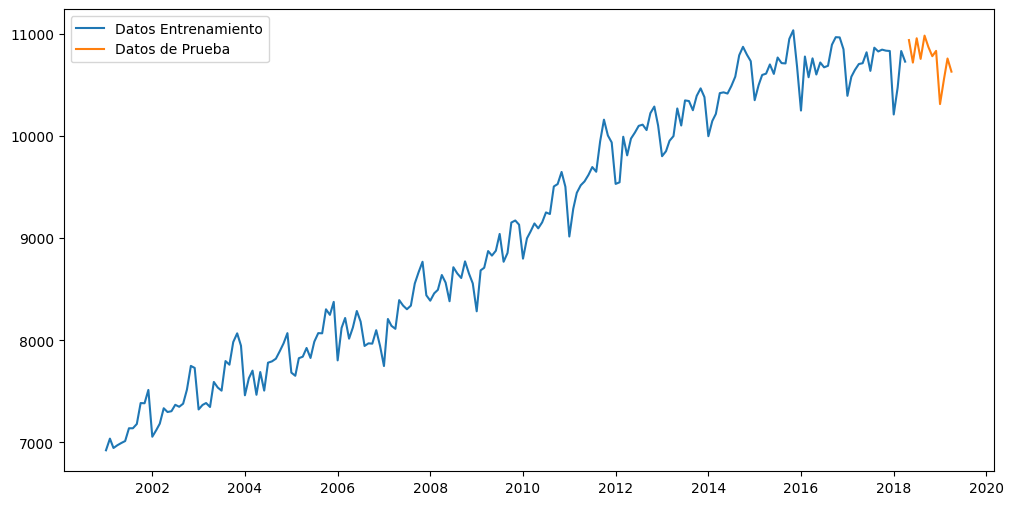

In [4]:
train_len = 208
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

## Se ajusta el modelo con el train y se observan los hiperparametros obtenidos en la optimización

MODELOS

**DATOS**

**Media Movil**

In [5]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [6]:
def calcular_media_movil_actual(train_td, order):
  ma= train_td.rolling(orden,min_periods=2).mean()
  ma_f= fore_ma(train_td,orden,12)
  rmse_ma = np.sqrt(mean_squared_error(test_td,ma_f ))
  r2_ma = r2_score(test_td, ma_f)
  #print("RMSE:", rmse_ma)
  #print("Coef R2:", r2_ma)
  return ma,orden,rmse_ma,r2_ma,ma_f

def calcular_media_movil(train_td, order):
  ma= train_td.shift().rolling(2,min_periods=2).mean()
  ma_f= fore_ma(train_td,orden,12)
  rmse_ma = np.sqrt(mean_squared_error(test_td,ma_f ))
  r2_ma = r2_score(test_td, ma_f)
  #print("RMSE:", rmse_ma)
  #print("Coef R2:", r2_ma)
  return ma,orden,rmse_ma,r2_ma,ma_f

In [7]:
# Suavizacion Media Movil (ordenes desde 2 a 5)
## Considerando dato actual
ordenes = [2, 3, 4, 5]

for orden in ordenes:
  ma_series, orden_, rmse_ma_, r2_ma_,ma_f_ = calcular_media_movil_actual(train_td, orden)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)

## Sin considerar dato actual
ordenes = [2, 3, 4, 5]

for orden in ordenes:
  ma_series, orden_, rmse_ma_, r2_ma_,ma_f_ = calcular_media_movil(train_td, orden)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil (Sin)', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)


<ipython-input-7-980d4e1d7beb>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)
<ipython-input-7-980d4e1d7beb>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)
<ipython-input-7-980d4e1d7beb>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)
<ipytho

**Suavizacion Exponencial Simple**



In [8]:
#combinaciones Exp Simple
combinaciones = [("add"), ("mul")]

In [9]:
for error in combinaciones:
  ets_model = ETSModel(endog=train_td["Ocupados"],error=error)
  ets_result = ets_model.fit()

  point_forecast=ets_result.forecast(12)

  ci = ets_result.get_prediction(start = point_forecast.index[0],
                                  end = point_forecast.index[-1])

  conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
  limits = ci.predicted_mean


  preds = pd.concat([limits, conf_forecast], axis = 1)
  preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
  rmse_es = np.sqrt(mean_squared_error(test_td,preds['Point_forecast']))
  #print(rmse_es)
  r2_es = r2_score(test_td, point_forecast)
  #print("Coef R2:", r2_es)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Simple', 'Configuración': error, 'RMSE': rmse_es, 'Coef R2': r2_es}, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-9-455d12965720>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Simple', 'Configuración': error, 'RMSE': rmse_es, 'Coef R2': r2_es}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-9-455d12965720>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Simple', 'Configuración': error, 'RMSE': rmse_es

Suavizacion Exponencial Lineal **(Holt)**



In [10]:
#combinaciones para HOLT
combinaciones = [("add", "add"), ("add", "mul"),("mul", "add"),("mul", "mul")]

In [11]:
for error,trend in combinaciones:
  ets_model = ETSModel(endog=train_td["Ocupados"],error=error,trend=trend)
  ets_result = ets_model.fit()

  point_forecast=ets_result.forecast(12)

  ci = ets_result.get_prediction(start = point_forecast.index[0],
                                  end = point_forecast.index[-1])

  conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
  limits = ci.predicted_mean


  preds_holt = pd.concat([limits, conf_forecast], axis = 1)
  preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
  rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
  #print(rmse_holt)
  r2_holt = r2_score(test_td, point_forecast)
  #print("Coef R2:", r2_holt)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal (Holt)', 'Configuración': error+'/'+trend, 'RMSE': rmse_holt, 'Coef R2': r2_holt}, ignore_index=True)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-8f25a1c9e89c>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal (Holt)', 'Configuración': error+'/'+trend, 'RMSE': rmse_holt, 'Coef R2': r2_holt}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-8f25a1c9e89c>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal (Holt)', 'Configur

**Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [12]:
combinaciones = [("add", "add", "add"), ("add", "add", "mul"), ("add", "mul", "add"), ("add", "mul", "mul"), ("mul", "mul", "mul"), ("mul", "add", "add"), ("mul", "add", "mul"), ("mul", "mul", "add")]

In [13]:
for error,trend,seasonal in combinaciones:

  ets_model = ETSModel(endog=train_td["Ocupados"],error=error,trend=trend,seasonal=seasonal )
  ets_result = ets_model.fit()

  point_forecast=ets_result.forecast(12)

  ci = ets_result.get_prediction(start = point_forecast.index[0],
                                  end = point_forecast.index[-1])

  conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
  limits = ci.predicted_mean


  preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
  preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
  rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
  #print("RMSE: ",rmse_hw_add,"PARAMETROS:",error,trend,seasonal)
  r2_hw = r2_score(test_td, point_forecast)
  #print("Coef R2:", r2_hw)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal de Winters (Holt-Winters)', 'Configuración': error+'/'+trend+'/'+seasonal, 'RMSE': rmse_hw_add, 'Coef R2': r2_hw}, ignore_index=True)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-13-bbb5f7df5b06>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal de Winters (Holt-Winters)', 'Configuración': error+'/'+trend+'/'+seasonal, 'RMSE': rmse_hw_add, 'Coef R2': r2_hw}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-13-bbb5f7df5b06>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizaci

In [14]:
Resultados

,Modelo,Configuración,RMSE,Coef R2
0,Suavizacion Media Movil,Orden 2,180.614057,0.020662
1,Suavizacion Media Movil,Orden 3,190.807500,-0.093000
2,Suavizacion Media Movil,Orden 4,218.760107,-0.436698
3,Suavizacion Media Movil,Orden 5,221.862444,-0.477736
4,Suavizacion Media Movil (Sin),Orden 2,180.614057,0.020662
5,Suavizacion Media Movil (Sin),Orden 3,190.807500,-0.093000
6,Suavizacion Media Movil (Sin),Orden 4,218.760107,-0.436698
7,Suavizacion Media Movil (Sin),Orden 5,221.862444,-0.477736
8,Suavizacion Exp Simple,add,186.786260,-0.047416
9,Suavizacion Exp Simple,mul,186.961145,-0.049378


**FIGURAS**

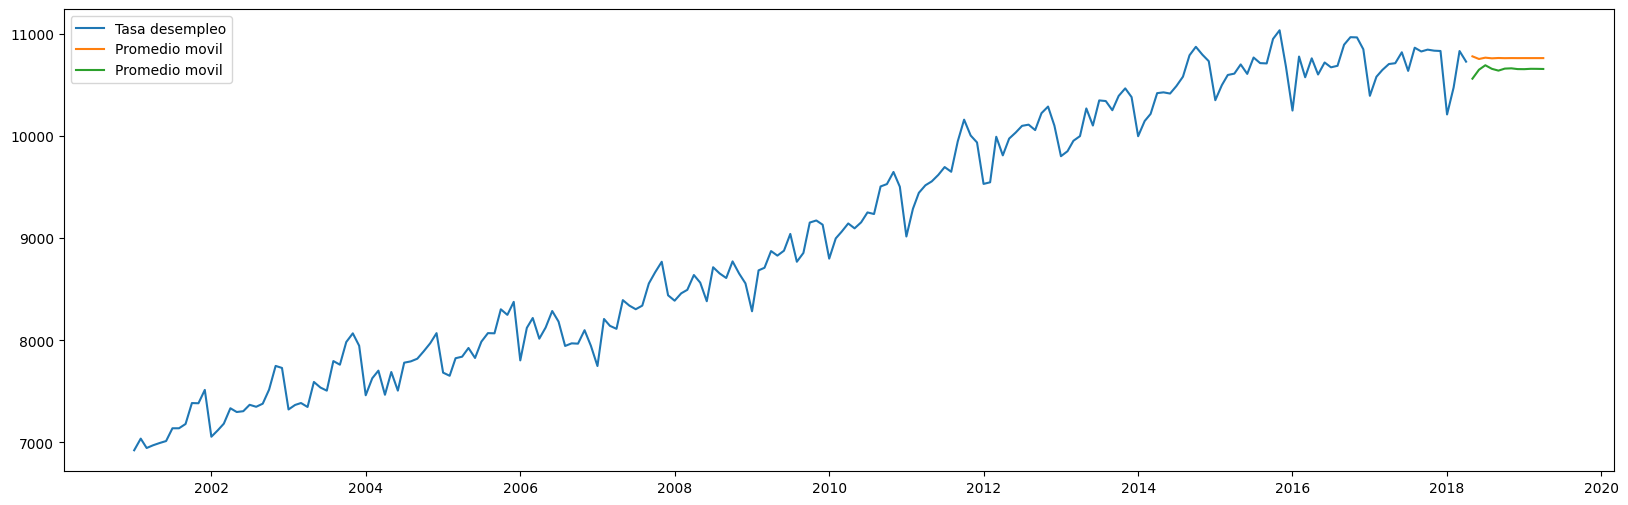

In [15]:
# Suavizacion Media Movil (ordenes desde 2 a 5)
## Sin considerar dato actual
ordenes = [2, 3, 4, 5]
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
for orden in ordenes:
  ma_series, orden_, rmse_ma_, r2_ma_,ma_f_ = calcular_media_movil(train_td, orden)
  #Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)
  if orden == 2 or orden == 4:
    plt.plot(ma_f_,label="Promedio movil")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-05-01    10720.369929  10363.684215  11077.055642
2018-06-01    10720.369929  10295.289386  11145.450471
2018-07-01    10720.369929  10236.466801  11204.273056
2018-08-01    10720.369929  10184.057514  11256.682343
2018-09-01    10720.369929  10136.332451  11304.407406
2018-10-01    10720.369929  10092.223016  11348.516842
2018-11-01    10720.369929  10051.014034  11389.725823
2018-12-01    10720.369929  10012.198987  11428.540870
2019-01-01    10720.369929   9975.403586  11465.336271
2019-02-01    10720.369929   9940.341967  11500.397890
2019-03-01    10720.369929   9906.789945  11533.949912
2019-04-01    10720.369929   9874.567848  11566.172009


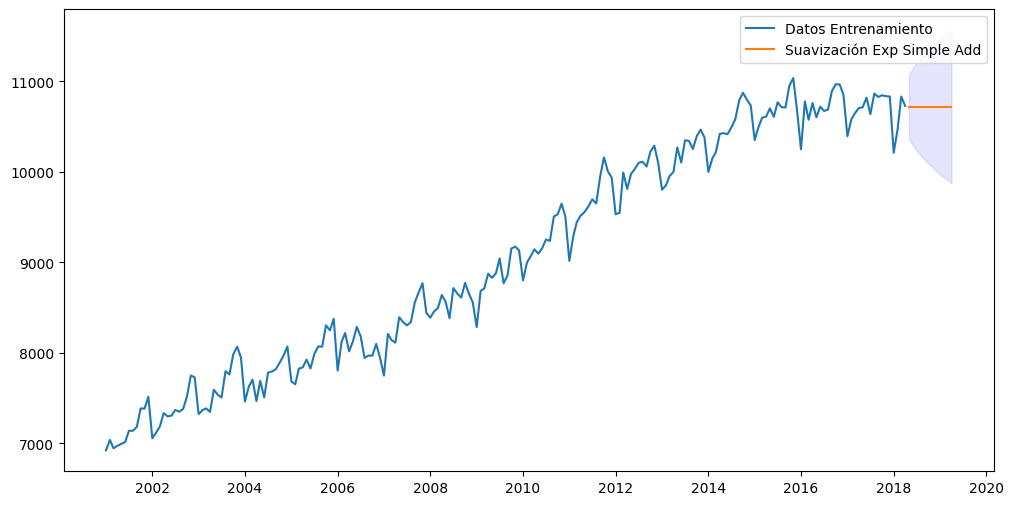

In [16]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="add")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exp Simple Add")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-05-01    10741.660188  10386.732789  11096.587587
2018-06-01    10759.348047  10345.697931  11172.998163
2018-07-01    10777.035906  10310.982234  11243.089577
2018-08-01    10794.723764  10280.639608  11308.807920
2018-09-01    10812.411623  10253.532258  11371.290988
2018-10-01    10830.099481  10228.928005  11431.270958
2018-11-01    10847.787340  10206.323578  11489.251102
2018-12-01    10865.475199  10185.355922  11545.594475
2019-01-01    10883.163057  10165.753270  11600.572844
2019-02-01    10900.850916  10147.306148  11654.395684
2019-03-01    10918.538775  10129.849218  11707.228331
2019-04-01    10936.226633  10113.249390  11759.203877


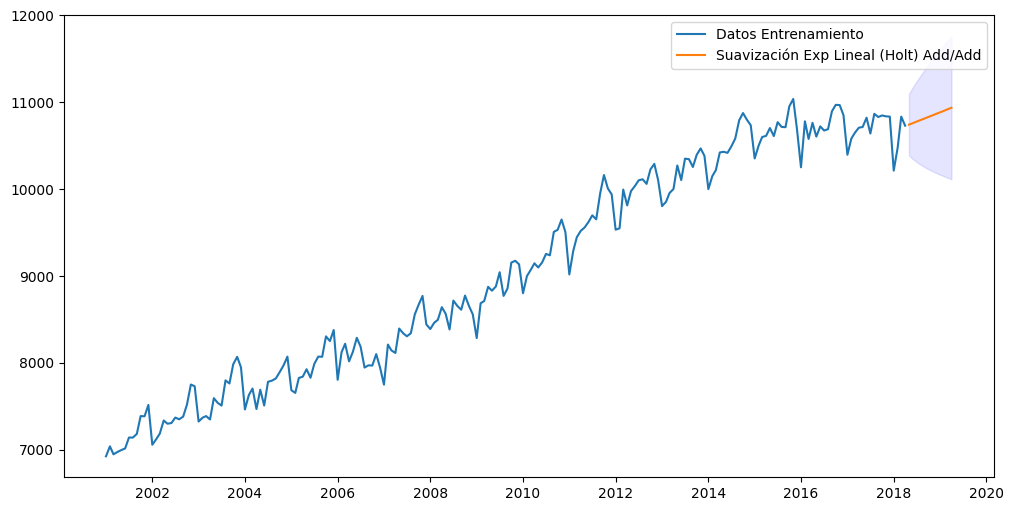

In [17]:


ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend="add")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exp Lineal (Holt) Add/Add")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-05-01    10798.400903  10576.753335  11020.048472
2018-06-01    10786.645311  10536.711164  11036.579458
2018-07-01    10864.222813  10588.888146  11139.557480
2018-08-01    10870.075531  10571.488948  11168.662115
2018-09-01    10934.690701  10614.532325  11254.849076
2018-10-01    11077.997076  10737.627438  11418.366715
2018-11-01    11113.088752  10753.638804  11472.538701
2018-12-01    11027.773060  10650.202260  11405.343861
2019-01-01    10640.970865  10246.106556  11035.835174
2019-02-01    10832.497382  10421.062569  11243.932196
2019-03-01    10914.432638  10487.066216  11341.799059
2019-04-01    10934.186609  10491.458497  11376.914721


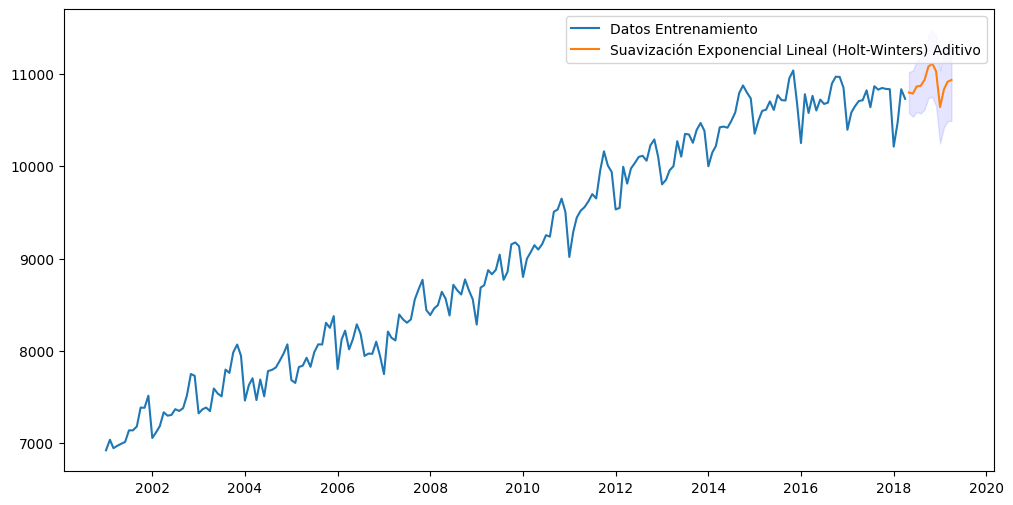

In [18]:
# Build model
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

## **CONCLUSION**

Con esto, el mejor modelo es Media movil de orden 2. por tanto haremos predicciones con este modelo

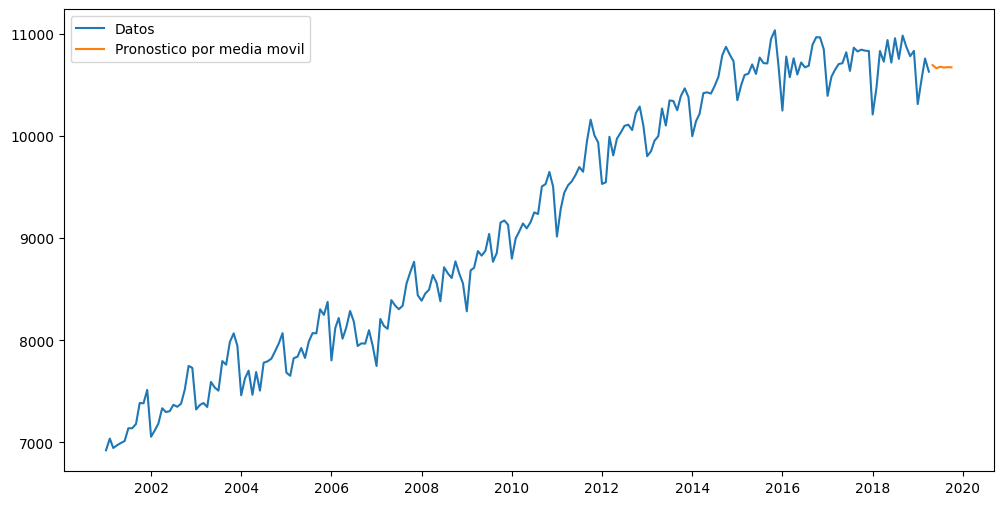

In [19]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.head()

train_td = data[["Ocupados"]] ## Haremos el pronostico con los datos completos

def fore_ma(datos, w, h):
    data = datos.copy()
    for x in range(1, h + 1):
        ind = data.index[-1]
        value = ind + pd.DateOffset(months=1)
        data.loc[value] = data[-w:].mean()
    return data[-h:]

ma_2_f = fore_ma(train_td, 2, 6)


fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos")
plt.plot(ma_2_f,label="Pronostico por media movil")
plt.legend()
plt.show()